# Microgrid sizing experiments for the “convex usage dependent cost” article

**TODOs**:
- iterative lifetime adjustment (for fixed_lifetime models)

Pierre Haessig, October 2024

In [1]:
using Microgrids

# Optimization
using JuMP
using HiGHS # Linear Programming solver

# Display
using Printf # pretty print results
using PyPlot

# Save results
using CSV, DataFrames

Check version of Microgrids.jl (v0.11.0 needed)

In [2]:
import Pkg
Pkg.status("Microgrids")

Status `~/.julia/environments/v1.11/Project.toml`
  [bd581358] Microgrids v0.11.0


Empty DataFrames to store paramters and results, to be contructed [Row by Row](https://dataframes.juliadata.org/stable/man/getting_started/#Constructing-Row-by-Row) with `push!`

In [3]:
# Empty DataFrames
df_params = DataFrame( # experiment parameters
    case=String[],
    shed_max=Float64[],
    fuel_price=Float64[],
    sto_lifetime_cycles=Float64[], sto_lifetime_calendar=Float64[],
    fixed_lifetimes=Bool[], gen_hours_assum=Float64[],
    n_ztan=Int[], relax_gain=Float64[])

Row,case,shed_max,fuel_price,sto_lifetime_cycles,sto_lifetime_calendar,fixed_lifetimes,gen_hours_assum,n_ztan,relax_gain
,String,Float64,Float64,Float64,Float64,Bool,Float64,Int64,Float64


In [4]:
df_results = DataFrame( # results
    lcoe_pwl=Float64[], lcoe_cvx=Float64[], lcoe_ns=Float64[],
    sto_cycles=Float64[], gen_hours=Float64[], gen_hours_lin=Float64[],
    xopt_gen=Float64[], xopt_sto=Float64[], xopt_pv=Float64[], xopt_wind=Float64[],
    topt=Float64[]
)

Row,lcoe_pwl,lcoe_cvx,lcoe_ns,sto_cycles,gen_hours,gen_hours_lin,xopt_gen,xopt_sto,xopt_pv,xopt_wind,topt
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64


## Problem setup

In [5]:
include("./example/Microgrid_Wind-Solar_data.jl");

Base Wind-Solar Microgrid project definition functions...


In [6]:
include("./Microgrid_JuMP_common.jl");

Microgrid optimization with JuMP common functions:
- CRF
- ts_reduction
- g_tan
- cons_Xann_usage!
- build_optim_mg_stage!
- setup_optim_mg_jump
- diagnostics_mg_jump
- optim_mg_jump
- simulate_alg


In [7]:
const tseries = load_microgrid_tseries();

loading times series from data/Ouessant_data_2016.csv...


In [8]:
"""Create a Microgrid project description of size `x`

x should be [
    power_rated_gen,
    energy_rated_sto,
    power_rated_pv,
    power_rated_wind
] (in kW or kWh)

Apart from the sizing, the project is based on parameters
defined by the function `create_mg_base` which
defaults to the globally defined `create_mg_base`.
This allows modifying some project parameters.
"""
function create_microgrid(x; create_mg_base=create_mg_base)
    # Create base microgrid
    mg = create_mg_base()

    # force ConsistentSalvage, necessary for comparison with LP approaches
    mg.project.salvage_type = ConsistentSalvage

    # Set the size
    mg.generator.power_rated = x[1] # power_rated_gen
    mg.storage.energy_rated = x[2] # energy_rated_sto
    mg.nondispatchables[1].power_rated = x[3] # power_rated_pv
    mg.nondispatchables[2].power_rated = x[4] # power_rated_wind

    return mg
end

x_base = [1000. 1000. 1000. 1000.]
mg_base = create_microgrid(x_base)

Microgrid{Float64}(Project(25, 0.05, 1.0, "€", ConsistentSalvage), [1453.0, 1331.0, 1214.0, 1146.0, 1078.0, 1035.0, 1032.0, 1072.0, 1142.0, 1208.0  …  1479.0, 1508.0, 1410.0, 1370.0, 1467.0, 1587.0, 1561.0, 1472.0, 1533.0, 1483.0], DispatchableGenerator{Float64}(1000.0, 0.0, 0.24, 1.0, 400.0, 0.02, 15000.0, 0.0, 1.0, 1.0, "L"), Battery{Float64}(1000.0, 350.0, 10.0, 15.0, 3000.0, 1.0, 1.0, 0.05, 0.0, 0.0, 1.0, 1.0), NonDispatchableSource[Photovoltaic{Float64}(1000.0, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.000000000000001e-5  …  0.45131, 0.30678, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 1200.0, 20.0, 25.0, 1.0, 1.0, 1.0), WindPower{Float64}(1000.0, [0.03184904690521816, 0.1104932647748532, 0.24596484619739856, 0.44422012231738006, 0.6554128208926687, 0.8470913237698507, 0.9579413031865969, 0.9735278942424532, 0.9837469734016646, 0.9903667231838823  …  0.011233045262998936, 0.018460507449516883, 0.023644167600765466, 0.02969747711584798, 0.036359043012900244, 0.03713796382151399,

### Sizing bounds for each component

In [9]:
Pload_max = maximum(tseries.Pload) # kW
@printf("Max load power: %.1f kW", Pload_max)
power_rated_gen_max = 1.2 * Pload_max
energy_rated_sto_max = 10.0 * Pload_max
power_rated_pv_max = 10.0 * Pload_max
power_rated_wind_max = 5.0 * Pload_max;

Max load power: 1707.0 kW

## Algebraic approach with usage dependent cost

### Model options

Load shedding (unserved load) bound, as a fraction of cumulated desired load energy:

In [10]:
shed_max = 0.0 # in [0,1]

0.0

Choose between fixed lifetimes (gen and storage) vs usage-dependant:

In [11]:
fixed_lifetimes = false

false

assumed generator operation hours (used if `fixed_lifetimes = false`)

In [12]:
gen_hours_assum = 2000. # in 0 – 8760 h/y

2000.0

else, use a relaxation gain to try to compensate the underestimation of e.g. the generator operating hours due to linearization. Default is 1.0. Use higher gain for stronger generator usage penalty.
- 2.0 is used for article

In [13]:
relax_gain = 2.0 # ≥ 1

2.0

### Test case options

test case modification functions

In [14]:
"""Modify Microgrid project by *multiplying* base price values:
- `sto`: `mg.storage.investment_price` 
- `gen`: `mg.generator.investment_price` 
- `fuel`: `mg.generator.fuel_price`
"""
function modify_mg_prices(;sto=1.0, gen=1.0, fuel=1.0)
    println("mg prices modifications: sto*=$sto, gen*=$gen, fuel*=$fuel")
    function modify_mg(mg)
        mg.storage.investment_price *= sto
        mg.generator.investment_price *= gen
        mg.generator.fuel_price *= fuel
        return mg # return mg to allow chaining
    end
    return modify_mg
end

"""Modify Microgrid project by *setting* storage lifetimes:
- `cal`: `mg.storage.lifetime_calendar` (years)
- `cyc`: `mg.storage.lifetime_cycles` (nb cycles)
"""
function modify_mg_lifetimes(;cal=nothing, cyc=nothing)
    cal_mod = cal !== nothing ? "cal=$cal y" : "cal unchanged"
    cyc_mod = cyc !== nothing ? "cyc=$cyc c" : "cyc unchanged"
    println("mg lifetime modification: $cal_mod, $cyc_mod")
    function modify_mg(mg)
        if cal !== nothing
            mg.storage.lifetime_calendar = cal
        end
        if cyc !== nothing
            mg.storage.lifetime_cycles = cyc
        end
        return mg # return mg to allow chaining
    end
    return modify_mg
end

modify_mg_lifetimes

Choice of base case: (using function composition `create_mg_base` → `modify_mg1` → ...)

In [15]:
create_mg_modified = modify_mg_lifetimes(cyc=1500) ∘
                     modify_mg_prices(fuel=2.0) ∘
                     create_mg_base;

mg lifetime modification: cal unchanged, cyc=1500 c
mg prices modifications: sto*=1.0, gen*=1.0, fuel*=2.0


### Algebraic model definition



#### Core model definition

Test `setup_optim_mg_jump` function to get JuMP model. Notice that this is not used later, because `setup_optim_mg_jump` is used internally by `optim_mg_jump`.

In [16]:
optimizer = HiGHS.Optimizer

mg_base, model_data = setup_optim_mg_jump(optimizer; shed_max)

model_data["model"]

Building stage problem with 365 days...
zero load shedding allowed
Usage-dependent generator lifetime model (relax_gain=1.0)
Xann constraints with z_tan=[0.2, 0.28, 0.37, 0.5, 0.68, 1.0, 1.7, 4.0]


A JuMP Model
├ solver: HiGHS
├ objective_sense: MIN_SENSE
│ └ objective_function_type: AffExpr
├ num_variables: 78849
├ num_constraints: 140198
│ ├ AffExpr in MOI.EqualTo{Float64}: 43803
│ ├ AffExpr in MOI.GreaterThan{Float64}: 8782
│ ├ AffExpr in MOI.LessThan{Float64}: 43801
│ ├ VariableRef in MOI.EqualTo{Float64}: 8760
│ ├ VariableRef in MOI.GreaterThan{Float64}: 35048
│ └ VariableRef in MOI.LessThan{Float64}: 4
└ Names registered in the model: none

Remarks on model size:

- stage problem has 78 849 variables (9*8760 + 9)

### Base Algebraic optim

Base case: for battery cycle life=1500 and fuel*=2 and 10 cost tangents and relax_gain=1 and 10 tangents.

Takes about 10-20s

In [17]:
optimizer = HiGHS.Optimizer

xalg, lcoe_alg, diagnostics, traj_alg, model_data, mg_alg = optim_mg_jump(optimizer;
    shed_max,
    #ndays=10,
    relax_gain,
    #z_tan=[0.20, 0.28, 0.37, 0.50, 0.68, 1.0, 1.7, 4.0],
    create_mg_base = create_mg_modified,
)
@printf("LCOE: %.6f €/MWh", lcoe_alg*1000)

Building stage problem with 365 days...
zero load shedding allowed
Usage-dependent generator lifetime model (relax_gain=2.0)
Xann constraints with z_tan=[0.2, 0.28, 0.37, 0.5, 0.68, 1.0, 1.7, 4.0]
 16.185273 seconds (3.04 M allocations: 187.049 MiB, 0.35% gc time, 3.97% compilation time: 91% of which was recompilation)
LCOE: 250.239373 €/MWh

In [18]:
round.(xalg; digits=1) # optimal sizing

4-element Vector{Float64}:
 1255.5
 5837.3
 2329.5
 1596.1

#### Expected results

for battery cycle life=1500, fuel*=2, 10 tangents and relax_gain=2

LCOE: `250.239 373` €/MWh

Sizing $x^*$:
```
 Gen  1255.5
 Sto  5837.3
 PV   2329.5
 Wind 1596.1
```

same,  but with **relax_gain=1**

LCOE: `243.023 740` €/MWh

Sizing $x^*$:
```
 Gen  1216.0
 Sto  4987.9
 PV   2132.0
 Wind 1575.9
```

In [19]:
"pretty-print NamedTuple or Dict"
function pprint(d, title=nothing)
    if title !== nothing
        println("$title:")
    end
    for k in keys(d)
        println("- $k: ", d[k])
    end
end

pprint(diagnostics.generator, "Generator diagnostics")
println()
pprint(diagnostics.storage, "Storage diagnostics")

Generator diagnostics:
- cost_share: 0.3449048222208222
- cost_share_fuel: 0.2814672373469457
- energy: 994146.0936787404
- load_share: 0.14673788563458876
- hours: 1809.0
- hours_lin: 1583.7121724658198
- lifetime: 8.291873963515755
- lifetime_hlin: 9.471418014452203
- CRF: 0.150271578062569
- CRF_hlin: 0.1351175173783697
- CRF_hlin_pwl: 0.13497830538014102

Storage diagnostics:
- cost_share: 0.1826803559394787
- energy_through: 1.6386143945716284e6
- load_share: 0.12093132647139042
- cycles: 140.35660110762856
- lifetime_cycles: 10.687064150618514
- lifetime: 10.687064150618514
- CRF: 0.12305413939425353
- CRF_pwl: 0.12301959130765426


#### Comparison with exact costs

1. exact nonlinear cvx cost (no PWL approx, but still using the linearized operation hours)
2. exact nonsmooth cost

In [20]:
_, stats, costs_cvx = simulate_alg(mg_alg, model_data,
                                           Smoothing(transition=1.0, gain=relax_gain))
costs_cvx.lcoe, lcoe_alg, lcoe_alg/costs_cvx.lcoe-1

(0.2502601106039112, 0.2502393733938677, -8.286262638279585e-5)

In [21]:
_, stats, costs_ns  = simulate_alg(mg_alg, model_data,
                                   NoSmoothing)
costs_ns.lcoe, lcoe_alg, lcoe_alg/costs_ns.lcoe-1

(0.2522183390570628, 0.2502393733938677, -0.00784624016871105)

Store base case params in global experiment DataFrame

In [22]:
p1 = (;
    case="Base case, rgain=1",
    shed_max,
    fuel_price=mg_alg.generator.fuel_price,
    sto_lifetime_cycles=mg_alg.storage.lifetime_cycles,
    sto_lifetime_calendar=mg_alg.storage.lifetime_calendar,
    fixed_lifetimes=false, gen_hours_assum=NaN,
    n_ztan=10, relax_gain=1.0
    )
p2 = (;
    case="Base case, rgain=2",
    shed_max,
    fuel_price=mg_alg.generator.fuel_price,
    sto_lifetime_cycles=mg_alg.storage.lifetime_cycles,
    sto_lifetime_calendar=mg_alg.storage.lifetime_calendar,
    fixed_lifetimes=false, gen_hours_assum=NaN,
    n_ztan=10, relax_gain
    )
push!(df_params, p1)
push!(df_params, p2)

Row,case,shed_max,fuel_price,sto_lifetime_cycles,sto_lifetime_calendar,fixed_lifetimes,gen_hours_assum,n_ztan,relax_gain
,String,Float64,Float64,Float64,Float64,Bool,Float64,Int64,Float64
1,"Base case, rgain=1",0.0,2.0,1500.0,15.0,false,NaN,10,1.0
2,"Base case, rgain=2",0.0,2.0,1500.0,15.0,false,NaN,10,2.0


### Effect of PWL approximation


Experiment design: from 2 tangents to 10

In [23]:
z_tan_list = [
    [], # 2 tangents 
    [0.50], # 3
    [0.28, 0.5, 1.0], # 5
    [0.20, 0.28, 0.37, 0.50, 0.68, 1.0, 1.7, 4.0] # 10
    ]
n_ztan = length(z_tan_list)

4

In [24]:
xalg_tab_pwl = zeros(n_ztan,length(xalg))
lcoe_tab_pwl = zeros(n_ztan,2) # 1) model, 2) exact nonlinear cvx

for i in 1:n_ztan
    z_tan = z_tan_list[i]
    println("Optimization with $(length(z_tan)) tangents")
    xalg, lcoe_alg, diagnostics, traj_alg, model_data, mg_alg = optim_mg_jump(optimizer;
        shed_max,
        #ndays=50,
        fixed_lifetimes=false,
        relax_gain,
        z_tan,
        create_mg_base = create_mg_modified,
        #model_custom
    )
    # recompute exact nonlinear cvx (but still smoothed/relaxed) cost (FAILS if ndays<365!)
    _, stats, costs = simulate_alg(mg_alg, model_data,
                                   Smoothing(transition=1.0, gain=relax_gain))
    # store results
    xalg_tab_pwl[i,:] = xalg'
    lcoe_tab_pwl[i,1] = lcoe_alg
    lcoe_tab_pwl[i,2] = costs.lcoe

    # Compute z variables to understand the relation with z_tan
    log1pi = log(1+mg_base.project.discount_rate)
    Tgen_hlin = diagnostics.generator.lifetime_hlin
    z_gen = 1/Tgen_hlin/log1pi
    T_sto_cycles = diagnostics.storage.lifetime_cycles
    z_sto = 1/T_sto_cycles/log1pi
    
    println("z=1/(T.log(1+i)):")
    println("- z_gen = $z_gen (lifetime $Tgen_hlin y)")
    println("- z_sto = $z_sto (lifetime $T_sto_cycles y)")
end

lcoe_tab_pwl

Optimization with 0 tangents
Building stage problem with 365 days...
zero load shedding allowed
Usage-dependent generator lifetime model (relax_gain=2.0)
Xann constraints with z_tan=Any[]
 14.536203 seconds (1.65 M allocations: 117.637 MiB, 0.46% gc time)
z=1/(T.log(1+i)):
- z_gen = 2.1083205115443637 (lifetime 9.72145089044094 y)
- z_sto = 1.864833974798723 (lifetime 10.990755526373354 y)
Optimization with 1 tangents
Building stage problem with 365 days...
zero load shedding allowed
Usage-dependent generator lifetime model (relax_gain=2.0)
Xann constraints with z_tan=Any[0.5]
 15.357508 seconds (1.65 M allocations: 117.639 MiB, 0.66% gc time)
z=1/(T.log(1+i)):
- z_gen = 2.108320511544363 (lifetime 9.721450890440945 y)
- z_sto = 1.8648339747987246 (lifetime 10.990755526373343 y)
Optimization with 3 tangents
Building stage problem with 365 days...
zero load shedding allowed
Usage-dependent generator lifetime model (relax_gain=2.0)
Xann constraints with z_tan=Any[0.28, 0.5, 1.0]
 14.4982

4×2 Matrix{Float64}:
 0.249423  0.250284
 0.249423  0.250284
 0.249601  0.250268
 0.250239  0.25026

In [25]:
xalg_tab_pwl

4×4 Matrix{Float64}:
 1246.01  6231.3   2371.4   1594.56
 1246.01  6231.3   2371.4   1594.56
 1254.02  5899.52  2368.49  1588.12
 1255.46  5837.33  2329.52  1596.12

Plot effect of nb of tangent on both LCOE. When ntan grows:
- model (pwl approx) LCOE increases
- but actual LCOE slighly decrease (since it's better approximated)!

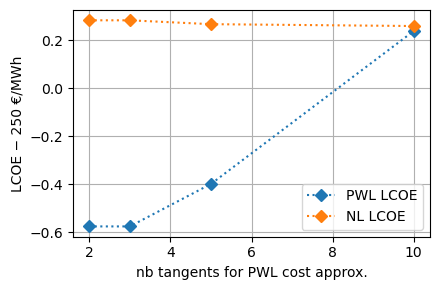

In [26]:
fig, ax = subplots(figsize=(4.5,3))
l = ax.plot([length(z_tan)+2 for z_tan in z_tan_list],
        lcoe_tab_pwl*1000 .- 250, "D:")
ax.grid(true)
ax.set(
    xlabel = "nb tangents for PWL cost approx.",
    ylabel = "LCOE − 250 €/MWh"
)
ax.legend(("PWL LCOE", "NL LCOE"))
fig.tight_layout();

In [27]:
p = (;
    case="Less tangents",
    shed_max,
    fuel_price=mg_alg.generator.fuel_price,
    sto_lifetime_cycles=mg_alg.storage.lifetime_cycles,
    sto_lifetime_calendar=mg_alg.storage.lifetime_calendar,
    fixed_lifetimes=false, gen_hours_assum=NaN,
    n_ztan=-1, relax_gain
    )
for n_ztan in [2,3,5]
    push!(df_params, p)
    df_params[end,"case"] = "Less tangents, n_ztan=$n_ztan"
    df_params[end,"n_ztan"] = n_ztan
end
df_params[end-2:end,:]

Row,case,shed_max,fuel_price,sto_lifetime_cycles,sto_lifetime_calendar,fixed_lifetimes,gen_hours_assum,n_ztan,relax_gain
,String,Float64,Float64,Float64,Float64,Bool,Float64,Int64,Float64
1,"Less tangents, n_ztan=2",0.0,2.0,1500.0,15.0,false,NaN,2,2.0
2,"Less tangents, n_ztan=3",0.0,2.0,1500.0,15.0,false,NaN,3,2.0
3,"Less tangents, n_ztan=5",0.0,2.0,1500.0,15.0,false,NaN,5,2.0


### Iterative approach to set relax_gain

The goal is to adjust the operating hours relaxation gain so as to imitate the true operating hours.

We have the true number of operating hours

$$ h_{oper} = \sum_k (P(k)>0) \Delta_t = \lVert P \rVert_0 . \Delta_t$$

and the linearized number of operating hours:

$$ \tilde{h}_{oper} =  \frac{\alpha}{P^{rated}} \sum_k P(k) \Delta_t 
                   = \alpha \frac{\lVert P \rVert_1 }{P^{rated}} \Delta_t$$


therefore, the true value for $\alpha$ to get the equaliy $ h_{oper} = \tilde{h}_{oper}$ is:

$$ \alpha = \frac{ \lVert P \rVert_0.P^{rated} }{ \lVert P \rVert_1  } $$

which can be interpreted as the inverse capacity factor when the generator is on. It is of course not possible to know this gain value beforehand. However, we use the a posteriori results one optimization run to set the gain for the next one, which yield the following update:

$$ \alpha^{(i+1)} =  \alpha^{(i)}  \frac{ h_{oper}^{(i)} }{ \tilde{h}_{oper}^{(i)} } $$

Put another way, with get that $\tilde{h}_{oper}^{(i+1)} = \alpha^{(i+1)}\frac{\lVert P \rVert_1^{(i+1)} }{P^{rated}} \Delta_t $ is in fact:

$$ \tilde{h}_{oper}^{(i+1)} = \frac{ \lVert P \rVert_0^{(i)} }{ \lVert P \rVert_1^{(i)} } \lVert P \rVert_1^{(i+1)} $$

and with some optional smoothing $\theta \in [0,1[$, the relaxation gain update can become:

$$ \alpha^{(i+1)} =  \theta \alpha^{(i)} + (1-\theta) \alpha^{(i)}  \frac{ h_{oper}^{(i)} }{ \tilde{h}_{oper}^{(i)} } $$



In [28]:
"""Optimize sizing of microgrid using JuMP: iteration `relax_gain`

and extract results

# Parameters
- same as `optim_mg_jump`, except that
- `fixed_lifetimes=false` is assumed, so `gen_hours_assum` is not needed
- `relax_gain_start` replaces `relax_gain`
- `relax_gain_smoothing` in [0, 1[ sets how slow relax_gain is updated. 0=no smoothing
- `n_iter`: number of iterations (default 6)

Returns:
xalg_tab, lcoe_tab, rgain_tab, diagnostics, traj_alg, model_data

(the last ones are from the last iteration)
"""
function optim_mg_iter_relgain(optimizer;
        shed_max=0.0,
        ndays=365,
        relax_gain_start = 1.0,
        relax_gain_smoothing = 0.0,
        n_iter=6,
        z_tan = [0.20, 0.28, 0.37, 0.50, 0.68, 1.0, 1.7, 4.0],
        create_mg_base=create_mg_base,
        model_custom=nothing,
    )

    xalg_tab = zeros(0,length(xalg)) # global previously computed xalg here
    lcoe_tab = zeros(0,3)  # 1) model, 2) exact nonlinear cvx, 3) exact nonsmooth
    rgain_tab = zeros(n_iter,1)
    relax_gain = relax_gain_start # init
    local diagnostics, traj_alg, model_data
    
    for i in 1:n_iter
        println("relax_gain iteration $i: $relax_gain")
        rgain_tab[i] = relax_gain # store relax_gain
        xalg, lcoe_alg, diagnostics, traj_alg, model_data, mg_alg = optim_mg_jump(optimizer;
            shed_max, ndays,
            fixed_lifetimes=false,
            relax_gain,
            z_tan,
            create_mg_base,
            model_custom
        )
        # recompute exact costs (FAILS if ndays<365!)
        _, stats, costs_cvx = simulate_alg(mg_alg, model_data,
                                           Smoothing(transition=1.0, gain=relax_gain))
        _, stats, costs_ns  = simulate_alg(mg_alg, model_data,
                                           NoSmoothing)
        
        # store results
        xalg_tab = [xalg_tab; xalg']
        lcoe_tab = [lcoe_tab;
                    lcoe_alg costs_cvx.lcoe costs_ns.lcoe]
        
        # correct next gain
        print("  hours/hours_lin: ")
        println(diagnostics.generator.hours / diagnostics.generator.hours_lin)
        relax_gain_target = relax_gain*diagnostics.generator.hours / diagnostics.generator.hours_lin
        relax_gain = relax_gain_smoothing*relax_gain + 
                     (1-relax_gain_smoothing)*relax_gain_target
    end
    
    return xalg_tab, lcoe_tab, rgain_tab, diagnostics, traj_alg, model_data
end

optim_mg_iter_relgain

In [29]:
xalg_tab, lcoe_tab, rgain_tab, diagnostics, traj_alg, model_data =  optim_mg_iter_relgain(optimizer;
    shed_max,
    #ndays=20,
    relax_gain_start = 1.0,
    n_iter=6,
    #z_tan=[0.20, 0.28, 0.37, 0.50, 0.68, 1.0, 1.7, 4.0],
    create_mg_base=create_mg_modified,
    #model_custom=nothing
)
lcoe_tab

relax_gain iteration 1: 1.0
Building stage problem with 365 days...
zero load shedding allowed
Usage-dependent generator lifetime model (relax_gain=1.0)
Xann constraints with z_tan=[0.2, 0.28, 0.37, 0.5, 0.68, 1.0, 1.7, 4.0]
 16.467092 seconds (1.65 M allocations: 117.648 MiB, 0.16% gc time)
  hours/hours_lin: 2.285082091467946
relax_gain iteration 2: 2.285082091467946
Building stage problem with 365 days...
zero load shedding allowed
Usage-dependent generator lifetime model (relax_gain=2.285082091467946)
Xann constraints with z_tan=[0.2, 0.28, 0.37, 0.5, 0.68, 1.0, 1.7, 4.0]
 10.404535 seconds (1.65 M allocations: 117.648 MiB, 0.34% gc time)
  hours/hours_lin: 0.9899655505490673
relax_gain iteration 3: 2.2621525507298794
Building stage problem with 365 days...
zero load shedding allowed
Usage-dependent generator lifetime model (relax_gain=2.2621525507298794)
Xann constraints with z_tan=[0.2, 0.28, 0.37, 0.5, 0.68, 1.0, 1.7, 4.0]
 10.611657 seconds (1.65 M allocations: 117.648 MiB, 3.7

6×3 Matrix{Float64}:
 0.243024  0.243056  0.252907
 0.252147  0.252175  0.252022
 0.251994  0.252022  0.252048
 0.252019  0.252048  0.252048
 0.252019  0.252048  0.252048
 0.252019  0.252048  0.252048

observation: at the second iteration, we get in fact a exact non smooth cost which is lower. This means the iteration is locked in a local minimum!

In [30]:
xalg_tab

6×4 Matrix{Float64}:
 1215.98  4987.93  2132.0   1575.9
 1249.59  6072.31  2384.13  1605.97
 1250.18  6046.1   2378.02  1608.66
 1250.18  6046.1   2378.02  1608.66
 1250.18  6046.1   2378.02  1608.66
 1250.18  6046.1   2378.02  1608.66

RMS sizing difference to the last one

In [31]:
sqrt.(sum( (xalg_tab .- xalg_tab[[end],:]).^2; dims=2))

6×1 Matrix{Float64}:
 1087.4245302782092
   27.04993670897564
    0.0
    0.0
    0.0
    0.0

Plot the convergence with relax_gain tuning:

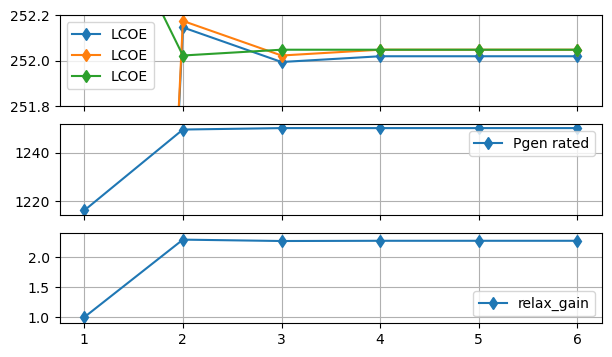

In [32]:
fig, ax = subplots(3,1, figsize=(7,4), sharex=true)

n_iter = length(rgain_tab)

ax[1].plot(1:n_iter, lcoe_tab*1000, "d-", label="LCOE")
ax[1].set_ylim(251, 253) # 365 days
ax[1].set_ylim(251.8, 252.2)


ax[2].plot(1:n_iter, xalg_tab[:,1], "d-", label="Pgen rated")
#ax[2].set_ylim(630, 670)

#ax[3].plot(2:n_iter, rgain_tab[2:end]./rgain_tab[1:end-1] .- 1,
#           "d-", label="relax_gain change")
#ax[3].set_ylim(-12e-3, +12e-3)
ax[3].plot(1:n_iter, rgain_tab,
           "d-", label="relax_gain")
ax[3].set_ylim(0.9, 2.4)

for axi in ax
    axi.grid(true)
    axi.legend()
end

In [33]:
p = (;
    case="Relax gain convergence",
    shed_max,
    fuel_price=mg_alg.generator.fuel_price,
    sto_lifetime_cycles=mg_alg.storage.lifetime_cycles,
    sto_lifetime_calendar=mg_alg.storage.lifetime_calendar,
    fixed_lifetimes=false, gen_hours_assum=NaN,
    n_ztan=10, relax_gain=rgain_tab[end]
    )
push!(df_params, p)   
df_params[end,:]

Row,case,shed_max,fuel_price,sto_lifetime_cycles,sto_lifetime_calendar,fixed_lifetimes,gen_hours_assum,n_ztan,relax_gain
,String,Float64,Float64,Float64,Float64,Bool,Float64,Int64,Float64
6,Relax gain convergence,0.0,2.0,1500.0,15.0,false,NaN,10,2.26598


## Fixed lifetime approach

tests:
- 2000 vs 3000 h/y for generator
- 15 vs 10 y calendar life for storage

In [34]:
create_mg_modified_cal10y = modify_mg_lifetimes(cal=8.0) ∘ create_mg_modified

x_fxlt, lcoe_fxlt, diagnostics, traj_fxlt, model_data, mg_fxlt = optim_mg_jump(optimizer;
    shed_max,
    #ndays=30,
    fixed_lifetimes=true,
    gen_hours_assum = 2600.,
    #gen_hours_assum = 3000.,
    relax_gain,
    #z_tan=[0.20, 0.28, 0.37, 0.50, 0.68, 1.0, 1.7, 4.0],
    #create_mg_base = modify_mg_lifetimes(cal=10) ∘ create_mg_modified,
    create_mg_base = create_mg_modified_cal10y,
)
@printf("LCOE: %.9f €/MWh (wrong)", lcoe_fxlt*1000)

mg lifetime modification: cal=8.0 y, cyc unchanged
Building stage problem with 365 days...
zero load shedding allowed
Fixed generator lifetime hypothesis: 5.769230769230769 y, assuming 2600.0  h/y of usage
  5.823262 seconds (1.64 M allocations: 115.996 MiB, 0.86% gc time)
LCOE: 257.858580665 €/MWh (wrong)

Sizing with fixed lifetime vs base sizing

In [35]:
round.([x_fxlt xalg]; digits=1) # optimal sizing

4×2 Matrix{Float64}:
 1226.0  1255.5
 2730.2  5837.3
 2080.9  2329.5
 1470.5  1596.1

###### Diagnostics: battery is underpriced by 30% (0.0963/0.1399=0.69):
- CRF being used: 0.0963, i.e. CRF(15 y)
- but cycle lifetime is 9.06 y → CRF should be 0.1399

In [36]:
pprint(diagnostics.generator, "Generator diagnostics")
println()
pprint(diagnostics.storage, "Storage diagnostics")

Generator diagnostics:
- cost_share: 0.4812913977351486
- cost_share_fuel: 0.38758803079387716
- energy: 1.4106480111093482e6
- load_share: 0.20821437396475298
- hours: 2756.0
- hours_lin: 2301.1969440636003
- lifetime: 5.44267053701016
- lifetime_hlin: 6.518346914502695
- CRF: 0.21439447165367895
- CRF_hlin: 0.18354017298601968
- CRF_hlin_pwl: 0.2038027253505108

Storage diagnostics:
- cost_share: 0.10025639801188961
- energy_through: 1.0397786884156885e6
- load_share: 0.0767366724247919
- cycles: 190.42491711891347
- lifetime_cycles: 7.877120403646043
- lifetime: 7.877120403646043
- CRF: 0.15669531638921044
- CRF_pwl: 0.15472181362768103


### Iterative lifetime adjustment

(not biggest priority though)

In [37]:
"""Optimize sizing of microgrid using JuMP: iteration of assumed fixed lifetimes

and extract results

# Parameters
- same as `optim_mg_jump`, except that
- `fixed_lifetimes=true` is assumed, so `gen_hours_assum` is not needed
- `gen_hours_assum_start` replaces `gen_hours_assum`
- `lifetimes_smoothing` in [0, 1[ sets how slow lifetimes are updated. 0=no smoothing
- `n_iter`: number of iterations (default 10)

remark: initial sto_lifetime_calendar is taken from the base mg

Returns:
xalg_tab, lcoe_tab, gen_hours_assum_tab, sto_lifetime_calendar_tab,
diagnostics, traj_alg, model_data

(the last ones are from the last iteration)
"""
function optim_mg_iter_lifetimes(optimizer;
        shed_max=0.0,
        ndays=365,
        gen_hours_assum_start = 3000,
        lifetimes_smoothing = 0.0,
        n_iter=10,
        z_tan = [0.20, 0.28, 0.37, 0.50, 0.68, 1.0, 1.7, 4.0],
        create_mg_base=create_mg_base,
        model_custom=nothing,
    )

    xalg_tab = zeros(0,length(xalg)) # global previously computed xalg here
    lcoe_tab = zeros(0,3)  # 1) model, 2) exact nonlinear cvx, 3) exact nonsmooth
    gen_hours_assum_tab = zeros(n_iter,1)
    sto_lifetime_calendar_tab = zeros(n_iter,1)
    # Init
    gen_hours_assum = gen_hours_assum_start # init
    create_mg_base_iter = create_mg_base
    sto_lifetime_calendar = create_mg_base_iter().storage.lifetime_calendar
    local diagnostics, traj_alg, model_data
    
    for i in 1:n_iter
        println("fixed lifetimes iteration $i: gen $gen_hours_assum h/y, sto $sto_lifetime_calendar y")
        # store lifetime parameters
        gen_hours_assum_tab[i] = gen_hours_assum
        sto_lifetime_calendar_tab[i] = sto_lifetime_calendar
        xalg, lcoe_alg, diagnostics, traj_alg, model_data, mg_alg = optim_mg_jump(optimizer;
            shed_max, ndays,
            fixed_lifetimes=true,
            gen_hours_assum,
            relax_gain=0, # set to 0 to since it should have no effect
            z_tan,
            create_mg_base = create_mg_base_iter,
            model_custom
        )
        # recompute exact costs (FAILS if ndays<365!)
        _, stats, costs_cvx = simulate_alg(mg_alg, model_data,
                                           Smoothing(transition=1.0, gain=relax_gain))
        _, stats, costs_ns  = simulate_alg(mg_alg, model_data,
                                           NoSmoothing)
        
        # store results
        xalg_tab = [xalg_tab; xalg']
        lcoe_tab = [lcoe_tab;
                    lcoe_alg costs_cvx.lcoe costs_ns.lcoe]
        
        # correct next lifetimes
        print("  gen hours/assumed: ")
        println(diagnostics.generator.hours / gen_hours_assum)
        gen_hours_assum = lifetimes_smoothing*gen_hours_assum +
                          (1-lifetimes_smoothing)*diagnostics.generator.hours
        print("  sto lifetime/assumed: ")
        println(diagnostics.storage.lifetime_cycles / sto_lifetime_calendar)
        sto_lifetime_calendar = lifetimes_smoothing*sto_lifetime_calendar +
                                (1-lifetimes_smoothing)*diagnostics.storage.lifetime_cycles
        create_mg_base_iter =  modify_mg_lifetimes(cal=sto_lifetime_calendar) ∘ create_mg_base
    end
    
    return xalg_tab, lcoe_tab, gen_hours_assum_tab, sto_lifetime_calendar_tab,
           diagnostics, traj_alg, model_data
end

optim_mg_iter_lifetimes

In [38]:
xalg_tab_fxlt, lcoe_tab_fxlt, gen_hours_assum_tab, sto_lifetime_calendar_tab, 
diagnostics, traj_alg, model_data =  optim_mg_iter_lifetimes(optimizer;
    shed_max,
    #ndays=20,
    gen_hours_assum_start = 3000,
    n_iter=6,
    #z_tan=[0.20, 0.28, 0.37, 0.50, 0.68, 1.0, 1.7, 4.0],
    create_mg_base=create_mg_modified,
    #model_custom=nothing
)
lcoe_tab_fxlt

fixed lifetimes iteration 1: gen 3000 h/y, sto 15.0 y
Building stage problem with 365 days...
zero load shedding allowed
Fixed generator lifetime hypothesis: 5.0 y, assuming 3000  h/y of usage
  5.421952 seconds (1.64 M allocations: 115.996 MiB, 0.90% gc time)
  gen hours/assumed: 0.6736666666666666
  sto lifetime/assumed: 0.6044015209688236
mg lifetime modification: cal=9.066022814532355 y, cyc unchanged
fixed lifetimes iteration 2: gen 2021.0 h/y, sto 9.066022814532355 y
Building stage problem with 365 days...
zero load shedding allowed
Fixed generator lifetime hypothesis: 7.422068283028204 y, assuming 2021.0  h/y of usage
  5.027171 seconds (1.64 M allocations: 115.996 MiB, 1.12% gc time)
  gen hours/assumed: 1.3028203859475507
  sto lifetime/assumed: 0.9039071398470901
mg lifetime modification: cal=8.194842752072407 y, cyc unchanged
fixed lifetimes iteration 3: gen 2633.0 h/y, sto 8.194842752072407 y
Building stage problem with 365 days...
zero load shedding allowed
Fixed generator

6×3 Matrix{Float64}:
 0.249383  0.252181  0.252883
 0.250713  0.254458  0.257758
 0.257708  0.255458  0.259242
 0.259233  0.255573  0.259468
 0.259467  0.255561  0.259502
 0.259502  0.255561  0.259502

In [39]:
xalg_tab_fxlt

6×4 Matrix{Float64}:
 1124.46  4961.18  2620.94  1448.62
 1204.65  3139.1   2133.18  1475.17
 1221.08  2816.53  2109.22  1463.98
 1226.78  2716.34  2076.3   1474.24
 1227.37  2705.76  2072.78  1477.07
 1227.37  2705.76  2072.78  1477.07

Observation: this iteration also reaches a steady state, but with a higher LCOE (259.5 €/MWh)

## Usage penalty approach

Model customization to penalize usage variables (instead of having the nonlinear influence of usage through annualized size)

In [40]:
"""penalize generator and usage in Cann
"""
function model_penalize_usage(md, mg)
    println("Penalized usage variant")
    model = md["model"]

    # Add usage variables (not added when fixed_lifetimes=true)
    # Generator usage:
    @assert "Ugen" ∉ keys(md) "Ugen shouldn't have been defined. Make sure fixed_lifetimes=true"
    md["Ugen"] = @variable(model, Ugen >= 0) # cumulated usage
    @constraint(model, Ugen == md["Egen"]*relax_gain/mg.generator.lifetime_hours); # kW/y
    # Storage usage
    @assert "Usto" ∉ keys(md) "Usto shouldn't have been defined. Make sure fixed_lifetimes=true"
    md["Usto"] = @variable(model, Usto >= 0) # cumulated usage
    @constraint(model, Usto == md["E_through_sto"]/(2*mg.storage.lifetime_cycles))
    
    # overwrite cost function with penalties
    md["Ugen_penal"] = Ugen_penal = mg.generator.investment_price * Ugen
    md["Usto_penal"] = Usto_penal = mg.storage.investment_price * Usto
    
    md["Cann_penal"] = Cann_penal = md["Cann"] + Ugen_penal + Usto_penal
    @objective(model, Min, Cann_penal)
end

model_penalize_usage

In [41]:
x_penal, lcoe_penal, diagnostics, traj_penal, model_data = optim_mg_jump(optimizer;
    shed_max,
    #ndays=30,
    fixed_lifetimes=true,
    #gen_hours_assum = 3000.,
    relax_gain,
    create_mg_base = create_mg_modified,
    model_custom = model_penalize_usage
)
@printf("LCOE: %.9f €/MWh (wrong)", lcoe_penal*1000)

Building stage problem with 365 days...
zero load shedding allowed
Fixed generator lifetime hypothesis: 5.0 y, assuming 3000.0  h/y of usage
Penalized usage variant
  6.356799 seconds (1.64 M allocations: 117.502 MiB, 0.83% gc time)
LCOE: 256.087752129 €/MWh (wrong)

Amount of penalties: +10% (not counted in LCOE!)

In [42]:
value(model_data["Cann_penal"])/value(model_data["Cann"])

1.0967920295542388

Sizing with usage penaly vs fixed lt vs base sizing
- even smaller battery

In [43]:
round.([x_penal x_fxlt xalg]; digits=1) # optimal sizing

4×3 Matrix{Float64}:
 1261.5  1226.0  1255.5
 2106.0  2730.2  5837.3
 1729.7  2080.9  2329.5
 1648.8  1470.5  1596.1

In [44]:
pprint(diagnostics.generator, "Generator diagnostics")
println()
pprint(diagnostics.storage, "Storage diagnostics")

Generator diagnostics:
- cost_share: 0.511087327435998
- cost_share_fuel: 0.40028634239898825
- energy: 1.44685928768005e6
- load_share: 0.21355922840204375
- hours: 2851.0
- hours_lin: 2293.8876767509573
- lifetime: 5.26131182041389
- lifetime_hlin: 6.539117042228446
- CRF: 0.22084810738289018
- CRF_hlin: 0.18304500651599442
- CRF_hlin_pwl: 0.23097479812826793

Storage diagnostics:
- cost_share: 0.05306956234796433
- energy_through: 778005.3575405942
- load_share: 0.05741754753340152
- cycles: 184.7091873603728
- lifetime_cycles: 8.120873798624093
- lifetime: 8.120873798624093
- CRF: 0.1528395203955612
- CRF_pwl: 0.09634228760924432


### Case when storage cycle life is not active

by setting calendar lifetime to 10 year (while the optimum is 10.x years)


#### Our method:

makes the best use of those 10 years, with T_cycle = 9.99 years !

In [45]:
create_mg_modified_cal10y = modify_mg_lifetimes(cal=10) ∘ create_mg_modified

x_alg10y, lcoe_alg10y, diagnostics, traj_alg10y, model_data = optim_mg_jump(optimizer;
    shed_max,
    #ndays=10,
    relax_gain,
    create_mg_base = create_mg_modified_cal10y,
)
@printf("LCOE: %.9f €/MWh", lcoe_alg10y*1000)

mg lifetime modification: cal=10 y, cyc unchanged
Building stage problem with 365 days...
zero load shedding allowed
Usage-dependent generator lifetime model (relax_gain=2.0)
Xann constraints with z_tan=[0.2, 0.28, 0.37, 0.5, 0.68, 1.0, 1.7, 4.0]
 15.307704 seconds (1.65 M allocations: 117.648 MiB, 0.63% gc time)
LCOE: 250.492323824 €/MWh

Sizing vs base sizing

In [46]:
round.([x_alg10y xalg]; digits=1) # optimal sizing

4×2 Matrix{Float64}:
 1184.4  1255.5
 5131.2  5837.3
 2296.4  2329.5
 1584.0  1596.1

Observation: T_cycle = 9.99 years !

In [47]:
pprint(diagnostics.storage, "Storage diagnostics")

Storage diagnostics:
- cost_share: 0.16728362196577656
- energy_through: 1.5406589676988088e6
- load_share: 0.11370212126847985
- cycles: 150.1255855113518
- lifetime_cycles: 9.991634636366344
- lifetime: 9.991634636366344
- CRF: 0.12958869413255772
- CRF_pwl: 0.12950457496545661


--- 

## Rerun all experiments

saved in `df_params`


CSV.write("df_$n_exp.csv", df)Save experiments in CSV table

In [48]:
df_params

Row,case,shed_max,fuel_price,sto_lifetime_cycles,sto_lifetime_calendar,fixed_lifetimes,gen_hours_assum,n_ztan,relax_gain
,String,Float64,Float64,Float64,Float64,Bool,Float64,Int64,Float64
1,"Base case, rgain=1",0.0,2.0,1500.0,15.0,false,NaN,10,1.0
2,"Base case, rgain=2",0.0,2.0,1500.0,15.0,false,NaN,10,2.0
3,"Less tangents, n_ztan=2",0.0,2.0,1500.0,15.0,false,NaN,2,2.0
4,"Less tangents, n_ztan=3",0.0,2.0,1500.0,15.0,false,NaN,3,2.0
5,"Less tangents, n_ztan=5",0.0,2.0,1500.0,15.0,false,NaN,5,2.0
6,Relax gain convergence,0.0,2.0,1500.0,15.0,false,NaN,10,2.26598


In [49]:
for row in eachrow(df_params)
    println("---")
    println("Processing case ", row.case)
    
    create_mg_iter = modify_mg_prices(fuel=row.fuel_price) ∘
        modify_mg_lifetimes(cyc=row.sto_lifetime_cycles, cal=row.sto_lifetime_calendar) ∘
        create_mg_modified

    if row.n_ztan == 2
        z_tan_iter = []
    elseif row.n_ztan == 3
        z_tan_iter = [0.50]
    elseif row.n_ztan == 5
        z_tan_iter = [0.28, 0.5, 1.0]
    elseif row.n_ztan == 10
        z_tan_iter = [0.20, 0.28, 0.37, 0.50, 0.68, 1.0, 1.7, 4.0]
    end
    
    topt = @elapsed xalg, lcoe_alg, diagnostics, traj_alg, model_data, mg_alg = optim_mg_jump(optimizer;
        row.shed_max,
        fixed_lifetimes=row.fixed_lifetimes,
        gen_hours_assum = row.gen_hours_assum,
        relax_gain = row.relax_gain,
        z_tan=z_tan_iter,
        create_mg_base = create_mg_modified,
        #model_custom
    )
    # recompute exact costs
    _, stats, costs_cvx = simulate_alg(mg_alg, model_data,
                                       Smoothing(transition=1.0, gain=relax_gain))
    _, stats, costs_ns  = simulate_alg(mg_alg, model_data,
                                       NoSmoothing)

    p = (
        lcoe_alg, costs_cvx.lcoe, costs_ns.lcoe,
        diagnostics.storage.cycles,
        diagnostics.generator.hours,
        diagnostics.generator.hours_lin,
        xalg[1], xalg[2], xalg[3], xalg[4],
        topt
    )
    push!(df_results, p) 
end

---
Processing case Base case, rgain=1
mg prices modifications: sto*=1.0, gen*=1.0, fuel*=2.0
mg lifetime modification: cal=15.0 y, cyc=1500.0 c
Building stage problem with 365 days...
zero load shedding allowed
Usage-dependent generator lifetime model (relax_gain=1.0)
Xann constraints with z_tan=[0.2, 0.28, 0.37, 0.5, 0.68, 1.0, 1.7, 4.0]
 12.191913 seconds (1.65 M allocations: 117.648 MiB, 0.39% gc time)
---
Processing case Base case, rgain=2
mg prices modifications: sto*=1.0, gen*=1.0, fuel*=2.0
mg lifetime modification: cal=15.0 y, cyc=1500.0 c
Building stage problem with 365 days...
zero load shedding allowed
Usage-dependent generator lifetime model (relax_gain=2.0)
Xann constraints with z_tan=[0.2, 0.28, 0.37, 0.5, 0.68, 1.0, 1.7, 4.0]
 13.461145 seconds (1.65 M allocations: 117.648 MiB, 0.57% gc time)
---
Processing case Less tangents, n_ztan=2
mg prices modifications: sto*=1.0, gen*=1.0, fuel*=2.0
mg lifetime modification: cal=15.0 y, cyc=1500.0 c
Building stage problem with 36

In [50]:
df_results

Row,lcoe_pwl,lcoe_cvx,lcoe_ns,sto_cycles,gen_hours,gen_hours_lin,xopt_gen,xopt_sto,xopt_pv,xopt_wind,topt
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.243024,0.250707,0.252907,147.761,2090.0,914.628,1215.98,4987.93,2132.0,1575.9,12.813
2,0.250239,0.25026,0.252218,140.357,1809.0,1583.71,1255.46,5837.33,2329.52,1596.12,13.7323
3,0.249423,0.250284,0.251948,136.478,1736.0,1542.98,1246.01,6231.3,2371.4,1594.56,11.3464
4,0.249423,0.250284,0.251888,136.478,1729.0,1542.98,1246.01,6231.3,2371.4,1594.56,11.5794
5,0.249601,0.250268,0.252148,140.747,1788.0,1571.41,1254.02,5899.52,2368.49,1588.12,11.069
6,0.252019,0.250275,0.252048,138.456,1746.0,1746.0,1250.18,6046.1,2378.02,1608.66,11.5383


In [51]:
df = hcat(df_params, df_results)

Row,case,shed_max,fuel_price,sto_lifetime_cycles,sto_lifetime_calendar,fixed_lifetimes,gen_hours_assum,n_ztan,relax_gain,lcoe_pwl,lcoe_cvx,lcoe_ns,sto_cycles,gen_hours,gen_hours_lin,xopt_gen,xopt_sto,xopt_pv,xopt_wind,topt
,String,Float64,Float64,Float64,Float64,Bool,Float64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,"Base case, rgain=1",0.0,2.0,1500.0,15.0,false,NaN,10,1.0,0.243024,0.250707,0.252907,147.761,2090.0,914.628,1215.98,4987.93,2132.0,1575.9,12.813
2,"Base case, rgain=2",0.0,2.0,1500.0,15.0,false,NaN,10,2.0,0.250239,0.25026,0.252218,140.357,1809.0,1583.71,1255.46,5837.33,2329.52,1596.12,13.7323
3,"Less tangents, n_ztan=2",0.0,2.0,1500.0,15.0,false,NaN,2,2.0,0.249423,0.250284,0.251948,136.478,1736.0,1542.98,1246.01,6231.3,2371.4,1594.56,11.3464
4,"Less tangents, n_ztan=3",0.0,2.0,1500.0,15.0,false,NaN,3,2.0,0.249423,0.250284,0.251888,136.478,1729.0,1542.98,1246.01,6231.3,2371.4,1594.56,11.5794
5,"Less tangents, n_ztan=5",0.0,2.0,1500.0,15.0,false,NaN,5,2.0,0.249601,0.250268,0.252148,140.747,1788.0,1571.41,1254.02,5899.52,2368.49,1588.12,11.069
6,Relax gain convergence,0.0,2.0,1500.0,15.0,false,NaN,10,2.26598,0.252019,0.250275,0.252048,138.456,1746.0,1746.0,1250.18,6046.1,2378.02,1608.66,11.5383


Bug: not same LCOE results with "Relax gain convergence" case between here and above!

In [52]:
CSV.write("cvx_article_experiments.csv", df)

"cvx_article_experiments.csv"